<a href="https://colab.research.google.com/github/jafr0822/MNA_ProyectoIntegrador-Equipo7/blob/main/Avance4_7_Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Integrador**


## **Tecnológico de Monterrey**
### **Maestría en Inteligencia Artificial Aplicada (MNA)**
#### Avance 4
#### Equipo 7


* Jorge Arturo Federico Rivera – A01250724
* Marco Antonio Vázquez Morales – A01793704
* Alejandro Jesús Vázquez Navarro - A01793146

# Índice

## I    Introducción
## II   EDA

1.   Estructura de datos
2.   Funciones Ad-hoc
3.   Dendograma
4.   Densidad
5.   Preprocesamiento
6.   Imputación de datos
7.   Imputación para variables
8.   Evaluación de Porosidad
9.   Análisis Bivariado
10.  Detección de Outliers
11.  Selección de variable dependiente

## III  Ingenieria de Características

1.   Construcción
2.   Normalización
3.   Selección y Extracción

## IV   Baseline

1.   Algoritmo
2.   Características importantes
3.   Sub y Sobreajuste
4.   Métricas
5.   Desempeño

## V    Modelos Alternativos

1. Preparación
2. Comparativa
3. Ajuste Fino

### Este trabajo tiene como finalidad crear un modelo que pueda predecir el riesgo de sufrir alguna afectación a la mujer o su feto en el proceso de embarazo, tomando como base los datos clínicos, metabólicos, genéticos y nutricionales. Se trata de encontrar una variable dependiente que permita detectar las emfermedades a tiempo para poder reducir el impacto negativo que puediera tener en uno o ambos casos.

### En primer termino se enlistan las variabales que se van a utilizar, en esta étapa identificamos 99 en donde las que estan en color naranja representan las posibles variables dependendientes, las que estan en azul son las variables explicativas, las que estan en color rojo serían las variables de salida.

### Posteriormente realizamos una revisión a los datos, luego quitamos las columnas que no serán útiles para después realizar un análisis exploratorio de los datos utilizando ydata-profilling y Sweetviz.

### Debido al número extenso de variables (96) generamos reportes estáticos en html para su mejor visualización.

### Estos pueden consultarse en estas ligas:
- [Reporte mínimo exploratorio](https://github.com/jafr0822/MNA_ProyectoIntegrador-Equipo7/blob/8a9e4300831ede90791258bd5b58acd44c456537/data/reports/profile1_min_report.html)

- [Reporte completo exploratorio](https://github.com/jafr0822/MNA_ProyectoIntegrador-Equipo7/blob/8a9e4300831ede90791258bd5b58acd44c456537/data/reports/profile1_exp_report.html)

- [Reporte realizado con sweetViz](https://github.com/jafr0822/MNA_ProyectoIntegrador-Equipo7/blob/8a9e4300831ede90791258bd5b58acd44c456537/data/reports/sv_report1.html)

# II EDA

## Estructura de datos

Despúes de una revisión con la parte médica, definimos las siguientes variables como la estrucutura base para la generación de los modelos predicitivos.
A continuación se listan y describen las variables que serán utilizadas para este proyecto.

Las variables en rojo serán consolidadas para la creación de la variable dependiente llamada `IndexMorbilidad`

La variable dependiente candidata (en marrón) era `sdg_parto`, se descartó debido a que solo está presente en el 50.5%  de las observaciones

## Instalamos librerias para colab

In [ ]:
#%pip install matplotlib-venn missingno sweetviz ydata-profiling
#%pip install --upgrade Pillow
#%pip install --upgrade scikit-learn
#%pip install git+https://github.com/MIDASverse/MIDASpy.git

import importlib

# List of libraries to install
libraries_to_install = [
    ("matplotlib_venn", "matplotlib_venn"),
    ("missingno", "missingno"),
    ("sweetviz", "sweetviz"),
    ("ydata_profiling", "pandas_profiling"),
    ("Pillow", "PIL"),
    ("scikit-learn", "sklearn"),
]

for package, module in libraries_to_install:
    try:
        importlib.import_module(module)
        print(f"{module} is already installed.")
    except ImportError:
        print(f"Installing {module}...")
        %pip install {package}


import pandas as pd
import sweetviz as sv
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sns

# CREATE REPORTS
_BLN_REPORTS = False



import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Creamos una función para calcular y graficar la porosidad del dataframe
def getPorosidad(df):

  porosidad = df.isnull().sum() / len(df)

  porosidad_df = pd.DataFrame({
      'Caracteristica': porosidad.index,
      'Porosidad': porosidad.values
  })

  # Ordenar el DataFrame por porosidad de mayor a menor
  porosidad_df = porosidad_df.sort_values(by='Porosidad', ascending=True)
  # Crear la gráfica de barras
  plt.figure(figsize=(6, 14))
  variables_interes = ['sdg_parto', 'preeclampsia', 'polihidramnios', 'hidramnios', 'infeccion_gesta', 'malformaciones_rn', 'aborto_rn', 'obito_rn', 'mnt_rn']

  colors = ['skyblue' if x not in variables_interes else 'orange' for x in porosidad_df['Caracteristica']]

  bars = plt.barh(porosidad_df['Caracteristica'], porosidad_df['Porosidad'], color=colors)  # Use barh for horizontal bars

  # Add value at the end of each bar
  for bar, value in zip(bars, porosidad_df['Porosidad']):
      plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f"{value:.2%}", va='center', ha='left')

  plt.xlabel('% Porosidad')
  plt.ylabel('Caracteristica')
  plt.title('Porosidad por Columna')
  plt.xticks(rotation=90, ha='right')
  plt.tight_layout()
  plt.show()

def getPorosidadQuintiles(df):

    porosidad = df.isnull().sum() / len(df)
    porosidad_df = pd.DataFrame({
        'Caracteristica': porosidad.index,
        'Porosidad': porosidad.values
    })

    # Ordenar el DataFrame por porosidad de mayor a menor
    porosidad_df = porosidad_df.sort_values(by='Porosidad', ascending=True)

    # Crear la gráfica de barras
    plt.figure(figsize=(6, 14))

    variables_interes = ['sdg_parto', 'preeclampsia', 'polihidramnios', 'hidramnios', 'infeccion_gesta', 'malformaciones_rn', 'aborto_rn', 'obito_rn', 'mnt_rn']
    colors = ['skyblue' if x not in variables_interes else 'orange' for x in porosidad_df['Caracteristica']]

    bars = plt.barh(porosidad_df['Caracteristica'], porosidad_df['Porosidad'], color=colors)  # Use barh for horizontal bars

    # Add value at the end of each bar
    for bar, value in zip(bars, porosidad_df['Porosidad']):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f"{value:.2%}", va='center', ha='left')

    # Añadir marcadores para los quintiles
    quintiles = porosidad_df['Porosidad'].quantile([0.2, 0.4, 0.6, 0.8])
    for quintile in quintiles:
        plt.axvline(x=quintile, color='red', linestyle='--', alpha=0.5)

    plt.xlabel('% Porosidad')
    plt.ylabel('Caracteristica')
    plt.title('Porosidad por Columna')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

#####################################################

def getVariablesUltimoQuintil(df):
    porosidad = df.isnull().sum() / len(df)
    porosidad_df = pd.DataFrame({
        'Caracteristica': porosidad.index,
        'Porosidad': porosidad.values
    })

    # Ordenar el DataFrame por porosidad de mayor a menor
    porosidad_df = porosidad_df.sort_values(by='Porosidad', ascending=True)

    # Calcular los quintiles de la porosidad
    quintiles = porosidad_df['Porosidad'].quantile([0.2, 0.4, 0.6, 0.8])

    # Filtrar características que están en el último quintil
    ult_quintil = porosidad_df[porosidad_df['Porosidad'] > quintiles[0.8]]

    return ult_quintil['Caracteristica'].tolist()

########################################################

# Creamos una función para separar las variables categóricas, numéricas
def extract_column_types(df):
    numeric_cols = []
    string_cols = []

    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            numeric_cols.append(col)
        elif df[col].dtype == 'object':
            string_cols.append(col)

    return numeric_cols, string_cols


########################################################

def plot_distribution(df):
    # Extraer columnas numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns

    # Calcular el número de filas y columnas para el mosaico
    num_cols = len(numeric_cols)
    num_rows = (num_cols + 1) // 2  # Redondeo hacia arriba

    # Crear una cuadrícula de subgráficos
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 6))
    axes = axes.flatten()  # Convertir la matriz de ejes en una lista plana

    # Iterar sobre cada columna numérica y crear una gráfica de distribución
    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], kde=True, color='skyblue', ax=axes[i])
        axes[i].set_title(f'Distribución de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')

    # Ocultar ejes sobrantes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

#######################################

def get_column_types(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    string_cols = df.select_dtypes(include=[object]).columns.tolist()
    #binary_cols = [col for col in df.columns if col not in numeric_cols and col not in string_cols]
    return numeric_cols, string_cols

#######################################

def identify_binary(data):

  binary_cols = []
  for col in data.columns:
    unique_values = data[col].dropna().unique()
    #print(f'Col name {col} unique values {unique_values}')

    if len(unique_values) == 3 and (set(unique_values) == {"", 0.0, 1.0}):  # Check for 0, 1 or "", 1

      binary_cols.append(col)
  return binary_cols


######################################

def detect_outliers_iqr(df):
    outliers = []
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outliers.extend(col_outliers)
    return list(set(outliers))

## Lectura de datos desde excel

In [ ]:
# Se agrega esta configuración para mostrar todas las variables en el método describe.().T
pd.options.display.max_columns = None


cols_to_include = [
    "id_gdg",
"biopsias",
"estado",
"edad_dx",
"imc_h",
"obs_h",
"peso_1",
"peso_2",
"peso_3",
"sdg_dx",
"gluc_dx_0",
"gluc_dx_60",
"gluc_dx_120",
"gluc_dx_180",
"dx_inicio",
"auc",
"ichos_pregesta",
"hta_pregesta",
"sop",
"hipotiroidismo",
"hipertiroidismo",
"consumo_alcohol",
"consumo_tabaco",
"anticonceptivo",
"ah_dm",
"ah_hta",
"ah_ob",
"ah_dg",
"no_gestas",
"ant_dg",
"ant_aborto",
"ant_obito",
"ant_mnt",
"ant_malformado",
"ant_macrosomico",
"cesarea_iter",
"ema",
"alta_paridad",
"estatura_baja",
"pgr",
"infeccion_pregesta",
"embarazo_multiple",
"preeclampsia",
"polihidramnios",
"hidramnios",
"infeccion_gesta",
"ac_fol_pregesta",
"ac_fol_gesta",
"sdg_fol",
"trim_fol",
"ac_fol_dosis_mg",
"modo_parto",
"sdg_parto",
"termino_rn",
"macrosomia_rn",
"malformaciones_rn",
"aborto_rn",
"obito_rn",
"mnt_rn",
"ins_dx",
"gluc_dx",
"crea_dx",
"urico_dx",
"tg_dx",
"ct_dx",
"hdl_dx",
"ldl_dx",
"apob_dx",
"lep_dx",
"adipo_dx",
"pcr_dx",
"origen_px",
"tiene_pareja",
"paciente_trabaja",
"escolaridad",
"puntos_ses",
"nivel_ses",
"trimestre_ev1",
"AcFolico_supl",
#"AcFolico_marca", # No tiene valor en este estudio
"AcFsup_dosis_mg",
"supl_preconcep",
"supl_1erTrim",
"Multi0_acfol1",
"iniciosupl_sdg",
"AcFolico_papa",
"Ins_1av",
"Gluc_1av",
"Col_1av",
"Tg_1av",
"LDL_1av",
"HDL_1av",
"CMB_1av",
"PCT_1av",
"CMB_2av",
"PCT_2av"


]

excel_file_1 = "data/base_multimorb_fase1_fase_2_clinicas_originales.xlsx"

df1_sheet1 = pd.read_excel(
    excel_file_1,
    sheet_name=0,
    usecols=cols_to_include,
)

df1_sheet2 = pd.read_excel(
    excel_file_1,
    sheet_name=1,
    usecols=cols_to_include,
)

df1_sheets = [
    df1_sheet1,
    df1_sheet2
]

df1 = pd.concat(df1_sheets)
df1.to_csv("primera_Salida.csv")
#df1.describe()

df1.describe(include="all").T

dfIds = df1[["id_gdg", "origen_px"]]

In [ ]:
df1.head(10)

In [ ]:
df1.tail(10)

## ydata-profiling

### Generación de análisis univariado y bi/multivariado

In [ ]:
if _BLN_REPORTS==True:
  profile1 = ProfileReport(
      df1,
      title="Minimal Profiling Report for df1",
      # explorative=True,
      minimal=True,
  )
  profile1.to_file("data/reports/profile1_min_report.html")

In [ ]:
if _BLN_REPORTS==True:
  profile1.to_notebook_iframe()

### Debido al tamaño del reporte, se prefirió generar un archivo html llamado  profile1_exp_report.html que está alojado en el repositorio o puede ser consultado en la siguiente liga [EDA_Extensivo](/content/data/reports/profile1_min_report.html):

In [ ]:
if _BLN_REPORTS==True:
  profile1_exp = ProfileReport(
      df1,
      title="Explorative Profiling Report for df1",
      explorative=True,
      # minimal=True,
  )
  profile1_exp.to_file("data/reports/profile1_min_report.html")

### sweetviz

In [ ]:
# Missingness Map

import missingno as msno
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(40, 40))  # Adjust size as needed

# Create the heatmap
msno.heatmap(df1, ax=ax)

# Reduce font size of tick labels (optional)
ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust size as needed

plt.show()

Esta gráfica nos permite identificar zonas de alta correlación con presencia y ausencia de variables.

Por ejemplo, la zona de variables ac_fol_pregesta, ac_fol_gesta, sdg_fol, trim_fol y ac_fol_dosis_mg tiene una ligera correlación positiva en presencia de biopsias.

Misma conducta podemos observarla con las variables trimestre_ev1, acFolico_supl, AcFolico_Marca, AcFsup_dosis_mg, supl_preconcep, supl_1erTrim, Multi0_acfol1, inicisupl_sdg, AcFolico_papa, Gluc_1av, Col_1av, Tg_1av, LDL_1av, HDL_1av, CMB_1av, PCT_1av.

También encontramos correlaciones positivas en presencia de datos con las siguientes pares de variables:

[trimestre_ev1, acFolico_supl, AcFolico_Marca, AcFsup_dosis_mg, supl_preconcep, supl_1erTrim, Multi0_acfol1, inicisupl_sdg, AcFolico_papa, Gluc_1av, Col_1av, Tg_1av, LDL_1av, HDL_1av, CMB_1av, PCT_1av]

<center>vs</center>

[modo_parto, sdg_parto, termino_rn (candidata a variable dependiente), macromosima_rn (candidata a variable dependiente), malformaciones_rn, aborto_rn, obito_rn, mnt_rn, ins_dx, crea_dx, urico_dx, aprob_dx, lep_dx, pcr_dx]

Estos últimos siendo parte del conjunto de marcadores bioquímicos.


### Dendrograma

Este gráfico proporciona información en forma de árbol generado mediante agrupación jerárquica y agrupa columnas que tienen fuertes correlaciones en nulidad.

Si varias columnas se agrupan en el nivel cero, esto significa que la presencia de nulos en una de esas columnas está directamente relacionada con la presencia o ausencia de nulos en las demás columnas. Cuanto más separadas estén las columnas en el árbol, menos probable será que los valores nulos estén correlacionados entre las columnas.



In [ ]:
fig, ax = plt.subplots(figsize=(40, 40))

msno.dendrogram(df1, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()

Como se mencionó, este gráfico nos permite entender diferentes grupos de columnas que guardan relación con su presencia o no de datos. Por ejemplo, el grupo de preeclampsia, polihidramnios e hidramnios están fuertemente correlacionados en nulidad. La presencia de una variable en este grupo indica que existe una alta probabilidad de la existencia de otra.

Esto es importante porque gracias a esta gráfica podemos determinar grupos de variables y determinar qué técnica de imputación de datos podemos realizar. Es decir, todo lo que esté relacionado con la glucosa, puede ser tratado con la misma técnica de imputación.

Inclusive podemos identificar clusters de columnas a nivel cero como obs_h, talla, estatura_baja, ev_1ertrim, ev_dieta, edad_dx y ema que indican tener una gran densidad de dato.

### Densidad

Además de los análisis anteriores, evaluamos el nivel de densidad de las características. Es decir:

$$ Porosidad = TotalCeldasVacias / TotalFilas
$$
​

Esto se calcula a continuación:

In [ ]:
from IPython.display import display, HTML

# Adjust the max width of output cells to fit the screen
display(HTML("<style>.container { width:100% !important; }</style>"))

# Hide the vertical scroll bar for output cells
display(HTML("<style>.output { overflow-y: hidden; }</style>"))


# Graficamos la porosidad inicial
getPorosidad(df1)

Las columnas en naranja son las variables que utilizaremos para el cálculo de la variable dependiente  `IndexMorbilidad`

Gráfica de quintiles para determinar qué variables podemos recomendar eliminar.

In [ ]:
getPorosidadQuintiles(df1)

Las siguientes variables que se encuentran en el último quintil, serán recomendada eliminarlas de la matriz de datos:

In [ ]:
getVariablesUltimoQuintil(df1)

variables_ultimo_quintil = ['adipo_dx', 'Multi0_acfol1', 'AcFsup_dosis_mg', 'trimestre_ev1', 'lep_dx', 'PCT_1av', 'CMB_1av', 'Gluc_1av', 'Tg_1av', 'Col_1av', 'HDL_1av',
 'LDL_1av', 'crea_dx', 'CMB_2av', 'PCT_2av', 'urico_dx', 'apob_dx', 'pcr_dx', 'Ins_1av']


df1.drop(columns =variables_ultimo_quintil, inplace=True)



Podemos observar que la variable dependiente candidata `sdg_parto` tiene un 49.5% de densidad. Esto no permitirá tener un modelo fiable, ya que, si optamos por la eliminación de filas sin variable dependiente, solo tendríamos **1,188 * (1-0.495) = 599** (redondeado) observaciones.

Por lo tanto, crearemos una variable dependiente (en la fase Ingeniería de Características) llamada `IndexMorbilidad` considerando los siguientes factores de morbilidad de la base de datos:



## Preprocesamiento

Realizaremos las siguientes acciones:
- Data imputation mediante el método multivariate feature imputation
- Generación de variable dependiente mediante la creación de un índice de morbilidades.

Además, eliminaremos las características que se encuentran en el último quintil de porosidad, esto previamente consultado con el equipo de investigación.


## Data Imputation

Utilizaremos el método Multivariate feature imputation que modela cada característica con valores perdidos en función de otras características y utiliza esa estimación para la imputación.

Lo hace de forma iterativa: en cada paso, una columna de características se designa como salida y y las demás columnas de características se tratan como entradas X. Se ajusta un regresor en (X, y) para y conocido.

In [ ]:
# Lo primero es sustituir los NaN's por celdas vacías para diferenciar limpiamente categóricas de numéricas.
# Un valor NaN confundirá una variable numérica con un vector = [0, 1, 'NA', null] en categórica

# Solo la variable macrosomia_rn es categórica

df_wo_spaces = df1.fillna('')
df_cleaned = df_wo_spaces.replace('NA', '')
df_cleaned = df_cleaned.replace('Na', '')
df_cleaned = df_cleaned.replace('na', '')

# Encontramos typos en la base. Colocaron 'o' (vocal o) en lugar de 0
# Será necesario reemplazar
df_cleaned = df_cleaned.replace('o', 0)
# Siguiente paso: identificar variables dicotómicas para ejecutar la correcta estrategia de imputación

binary_features = identify_binary(df_cleaned.copy())  # Use a copy to avoid modifying original data
all_cols = set(df_cleaned.columns)


cols_to_remove_from_numeric =["macrosomia_rn", "id_gdg", "origen_px"]

numeric_features = [x for x in all_cols if x not in binary_features]
numeric_features = [x for x in numeric_features if x not in cols_to_remove_from_numeric]

categorical_features  =["macrosomia_rn"]

#df_cleaned[binary_columns] = df_cleaned[binary_columns].astype(bool)

print(f"Columnas dicotómicas: {binary_features}")
print(f"Columnas numéricas: {numeric_features}")
print(f"Columnas categorica: {categorical_features}")

df_cleaned['macrosomia_rn'] = df_cleaned['macrosomia_rn'].astype(str)

df_cleaned.to_csv("salida.csv")

Eliminaremos las variables `id_gdg` y `origen_px` pues son identificadores. No es necesario imputarlos.

Ahora, será necesario aplicar un algoritmo de imputación, en este caso hemos optado por Multivariate feature imputation

## Data imputation para variables

In [ ]:

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

df_cleaned.replace('', np.nan, inplace=True)


# Create pipeline for preprocessing
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with mode
    ('binarizer', FunctionTransformer(lambda x: x.astype(bool), validate=False))  # Convert to binary
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Scale numerical features if needed
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical variables
])

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', binary_transformer, binary_features),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline.fit(df_cleaned)

# Fit and transform the data
transformed_data = pipeline.transform(df_cleaned)


# Get feature names
binary_feature_names = binary_features
numeric_feature_names = numeric_features
categorical_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = binary_feature_names + numeric_feature_names + list(categorical_feature_names)

transformed_df = pd.DataFrame(transformed_data, columns=feature_names)
print(transformed_df)

transformed_df.to_csv("final.csv")


In [ ]:
# Es necesario ahora añadir el identificador y el estado origen de la República Mexicana de la madre
dfIds.reset_index(drop=True, inplace=True)
transformed_df.reset_index(drop=True, inplace=True)

dfFinal = pd.concat([dfIds, transformed_df], axis=1)

dfFinal.head()
dfFinal.to_csv("dfV1.csv")

Hemos realizado la imputación de datos, comprobemos.


In [ ]:
plot_distribution(transformed_df)

En un vistazo a las gráficas de distribución se puede observar que ya tenemos una densidad valiosa y además, nuestra imputación en las variables binarias fue exitosa pues tenemos gráficas con valores de 1 o 0. Además, hemos escalado las variables numéricas para la preparación de la ingeniería de características.

## Evaluación de porosidad

En este código, revisamos cuántos valores nulos tenemos:


In [ ]:
null_counts_by_column = transformed_df.isnull().sum(axis=0)
null_counts_by_column

Ahora la gráfica para verificar:

In [ ]:
getPorosidad(transformed_df)

## Análisis bivariado

A continuación, realizaremos el análisis bivariado para identificar relaciones interesantes como correlaciones entre variables. El objetivo será eliminar dichas variahbles o aplicar alguna transformación para generar un entrenamiento más rápido.

In [ ]:
# Para una mejor visualización de las correlaciones, usaremos un heatmap
plt.figure(figsize=(40, 20))
sns.heatmap(transformed_df[numeric_features].corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

### Observaciones análisis bivariado.

- Peso_1, Peso_2 y Peso_3 tienen una correlación positiva con el imc_h
- Existe una correlación de ct_dx y tg_dx
- Encontramos una correlación positiva fuerte con ct_dx e idl_dx
- Peso_3 está fuertemente correlacionada con Peso_1
- También Peso_2 tiene una correlación positiva con Peso_1
- Gluc_dx_60 tiene una correlación positiva con auc
- Gluc_dx_120 guarda una correlación positiva con auc
- Gluc_d_x 0 con auc
- Gluc_dx_180 con auc
- Las variables relacionadas con glucosa_0_dx, 60_dx, 120_dx y 180_dx guarda correlaciones positivas
- iniciosupl_sdg también tiene una correlación positiva con sdg_fol
-idl_dx está correlacionada positivamente con ct_dx
- nivel_ses con puntos_ses también están fuertemente correlacionada positivamente

En general, un grupo de variables altamente correlacionadas no traerán información adicional al modelo e incrementarán la complejidad del algoritmo, esto aumentará el riesgo de comenter errores. Por tal motivo, se realizará una transformación del dataset con PCA para combatir la gran dimensionalidad del dataframe curado.

## Detección de Outliers

A continuación, ejecutaremos código para detección de outliers

In [ ]:
dfOutliers = transformed_df[numeric_features]
outliers_IQR = detect_outliers_iqr(dfOutliers)

# Create boxplot for each numerical variable
plt.figure(figsize=(14, 6))
sns.boxplot(data=dfOutliers, orient='h')
plt.title("Boxplot of Numerical Variables")
plt.xlabel("Values")
plt.ylabel("Variables")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Ahora sí es claro saber qué variables tienen outliers. Dependiendo del modelo a elegir posteriormente, será importante revisar si será necesario aplicar alguna transformación como box-cox para evitar problemas al momento de entrenar. Considerar que la metodología CRISP nos permite iterar entre fases con lo cual podemos experimentar con algoritmos que no son muy sensibles a los outliers como Random Forest.

## Selección de variable dependiente

En conjunto con el equipo médico, se ha decidido que la variable dependiente será llamada  `IndexMorbilidaderá` compuesta por la suma de presencias en cada una de las siguientes variables:

- malformaciones_rn
- aborto_rn
- obito_rn
- mnt_rn
- preeclampsia
- polihidramnios
- hidramnios
- infeccion_gesta

Es decir, `IndexMorbilidad` tendrá la siguiente escala:

- **Clase A**. Si contiene 8 de ellas
- **Clase B**. Si contiene entre 4 y 7 de ellas
- **Clase C**. Si contiene entre 1 y 3 de ellas
- **Clase D**. Si no contiene ninguna


In [ ]:
proposed_y_columns = [
    "malformaciones_rn",
    "aborto_rn",
    "obito_rn",
    "mnt_rn",
    "preeclampsia",
    "polihidramnios",
    "hidramnios",
    "infeccion_gesta",
]

X = transformed_df.copy().drop(columns=proposed_y_columns)

wip_y = transformed_df.copy()[proposed_y_columns]

wip_y["sum"] = wip_y.sum(axis=1)

value_ranges = [0, 1, 4, 7, 8]
bin_labels = ["D", "C", "B", "A"]

wip_y["IndexMorbilidad"] = pd.cut(wip_y["sum"], bins=value_ranges, labels=bin_labels, right=False)

# wip_y[wip_y["sum"]>=1].describe()

y = wip_y.copy()["IndexMorbilidad"]

y.describe()

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Elbow Method for Choosing Number of Components")
plt.grid(True)
plt.show()

In [ ]:
threshold = 0.99
threshold_index = np.argmax(np.cumsum(pca.explained_variance_ratio_) > threshold)
print("Number of Components required to maintain at least {:.2%} of variance: {}".format(threshold, threshold_index+1))

In [ ]:
pca_threshold = PCA(n_components=threshold_index+1)
pca_threshold.fit(X)
X_pca = pca_threshold.transform(X)
X_pca

## Clustering with K-means after applying PCA dimensionality reduction

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_range = range(2, 6)

fig, axs = plt.subplots(
    len(cluster_range),
    1,
    figsize=(8, len(cluster_range) * 4),
    # subplot_kw=dict(projection="3d") # Uncomment for 3D projection
)

for i, n_clusters in enumerate(cluster_range):
    kmeans = KMeans(n_clusters=n_clusters, random_state=22)
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)

    axs[i].scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        # X_pca[:, 2], # Uncomment for 3D projection
        c=cluster_labels,
        cmap="viridis",
    )
    axs[i].set_title(f"K-means  with {n_clusters} Clusters & Silhouette Score: {silhouette_avg}")
    axs[i].set_xlabel("Principal Component 1")
    axs[i].set_ylabel("Principal Component 2")
    # axs[i].set_zlabel("Principal Component 3") # Uncomment for 3D projection
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Ingeniería de características

## 1. Construcción


Tomaremos el dataframe `dfPreparado` que preparamos en la **Fase I**, aplicaremos la construcción de la variable dependiente y la inclusión de nuevas características. Por ejemplo, la variable `prematurez` se basará en el número de semanas de la variable `sdg_parto`.

A continuación las reglas de creación de características:

- **Prematurez** [variable nueva] En función al valor de la variable `sdg_parto` se determinará si el valor es **1** o **0**. La regla es: Si el valor es menor a 36, entonces será prematuro (1), caso contrario el valor será no prematuro (0).
- **EscalaRiesgo** [variable dependiente] Clasificación que tomará como base la suma de '1' en las 8 características indicadas por el cuerpo médico + nueva característica: `prematurez`. Con base en este valor, obtendremos los siguientes valores:
  - **A**: Alto riesgo: Puntuación 3 y 4
  - **B**: Medio riesgo: Puntuación entre 1 y 2
  - **C**: Bajo Riesgo: Puntuación 0

- **Clúster asociado** Después de correr un algoritmo de clustering, agregaremos al dataframe _dfPreparado_ el número de clúster asociado.

Además, crearemos variables con one hot encoding para la variable `macrosomia_rn`. Dicha variable tiene un vector de valores que comprende ratios, por ejemplo: 1/0 y 0/0


### 1.1. Funciones ad hoc

In [ ]:
def definePrematurez(sdg_parto):
  if sdg_parto > 36:
    return 0
  else:
    return 1

def defineClase(valor_IndexMorbilidad):
  if valor_IndexMorbilidad ==3 or valor_IndexMorbilidad==4:
    return "A"
  elif valor_IndexMorbilidad ==1 or valor_IndexMorbilidad==2:
    return "B"
  else:
    return "C"

def identify_binary(data):

  binary_cols = []
  for col in data.columns:
    unique_values = data[col].dropna().unique()
    #print(f'Col name {col} unique values {unique_values}')

    if len(unique_values) == 2 and (set(unique_values) == {0, 1}):

      binary_cols.append(col)
  return binary_cols

### 1.2 Librerías

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_samples, silhouette_score

# Para el clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


### 1.3 Carga de datos

In [ ]:
# Adquisisicón de datos

dfPreparado = pd.read_csv("data/dataset_proxima_fase.csv", encoding='utf8')
dfIds = dfPreparado[['id_gdg', 'origen_px']]
dfPreparado.head()

### 1.4 Variable Prematurez

In [ ]:
dfPreparado["prematurez"] = dfPreparado['sdg_parto'].apply(lambda x:definePrematurez(x))

#### 1.4.1 Revisar distribución de la nueva variable.

In [ ]:
prematurez_counts = dfPreparado['prematurez'].value_counts()
prematurez_counts = prematurez_counts.sort_index()
plt.bar(prematurez_counts.index, prematurez_counts.values, color='skyblue')
plt.xticks(list(map(int, prematurez_counts.index)))

plt.title('Prematurez Bar Chart')
plt.xlabel('Prematurez')
plt.ylabel('Count')
plt.show()

### 1.5 Variable dependiente

In [ ]:
lst_IndexMorbilidad = ['malformaciones_rn', 'aborto_rn','obito_rn','mnt_rn','preeclampsia', 'polihidramnios', 'hidramnios', 'infeccion_gesta', 'prematurez']
dfPreparado["IndexMorbilidad"] = dfPreparado[lst_IndexMorbilidad].sum(axis=1)
dfPreparado["EscalaRiesgo"] =  dfPreparado['IndexMorbilidad'].apply(lambda x:defineClase(x))

#### 1.6 Revisar la distribución de la variable dependiente **EscalaRiesgo**

In [ ]:
escala_riesgo = dfPreparado['EscalaRiesgo'].value_counts()
escala_riesgo = escala_riesgo.sort_index()
plt.bar(escala_riesgo.index, escala_riesgo.values, color='blue')
plt.title('Escala Riesgo Bar Chart')
plt.xlabel('Escala Riesgo')
plt.ylabel('Count')
plt.show()

In [ ]:
dfPreparado.to_csv("test.csv")

## 2. Normalización

En esta fase, realizaremos escalamiento de las variables numéricas pues, derivado del análisis de la **Fase 1** encontramos diferentes outliers que pueden desestabilizar el modelo base y subsecuentes.

Utilizaremos un Pipeline para crear la canalización para aplicar las transformaciones pertinentes.

In [ ]:
binary_features = identify_binary(dfPreparado)

all_cols = set(dfPreparado.columns)
cols_to_remove_from_numeric =["macrosomia_rn", "id_gdg", "origen_px"]

numeric_features = [x for x in all_cols if x not in binary_features]
numeric_features = [x for x in numeric_features if x not in cols_to_remove_from_numeric]
numeric_features.remove("IndexMorbilidad")
numeric_features.remove("EscalaRiesgo")
numeric_features.remove("anticonceptivo")

categorical_features  =["macrosomia_rn", "anticonceptivo"]

print(binary_features)

In [ ]:

# Create pipeline for preprocessing
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with mode
    ('binarizer', FunctionTransformer(lambda x: x.astype(bool), validate=False))  # Convert to binary
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale numerical features if needed
])

categorical_transformer = Pipeline(steps=[

    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical variables
])

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', binary_transformer, binary_features),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline.fit(dfPreparado)

# Fit and transform the data
transformed_data = pipeline.transform(dfPreparado)


# Get feature names
binary_feature_names = binary_features
numeric_feature_names = numeric_features
categorical_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = binary_feature_names + numeric_feature_names + list(categorical_feature_names)

transformed_df = pd.DataFrame(transformed_data, columns=feature_names)
transformed_df.to_csv("final.csv")

## 3. Selección / Extracción


En esta fase incluiremos la evaluación por clustering y agregaremos como característica de identificación el cluster identificado.

Esto se realiza hasta esta fase debido a que se procesaron, imputaron y escalaron primero los datos.


### 3.1 Evaluación del número óptimo de clústers

De acuerdo a esta primera evaluación, es posible apreciar que **3** es el número adecuado de clusters para el dataset. Podemos ver cómo la curva "rompe" en el cluster 3. Confirmaremos nuestra hipótesis con la gráfica de silueta.

In [ ]:
pca = PCA(n_components=2)
pca.fit(transformed_df)
df_pca = pca.transform(transformed_df)


distortions = []
for i in range(1, 11):  # Test cluster numbers from 1 to 10
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_pca)
    distortions.append(kmeans.inertia_)


plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Chart')
plt.xlabel('Número de clusters')
plt.ylabel('Distortion')
plt.xticks(range(1, 11))
plt.show()



Ahora la gráfica de clustering:

In [ ]:
optimal_num_clusters = 3


kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_pca)


plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on PCA')
plt.colorbar(label='Cluster')
plt.show()

En este código evaluamos el score de silueta para entender qué tan bien están clasificados los puntos de acuerdo al número de clúster.

- **Valores cercanos a 1:** Puntos bien clasificados y cercanos al centroide de grupo.
- **Valores cercanos a 0:** Puntos entre el límite de 2 clusters
- **Valores cercanos a -1:** Puntos mal clasificados y alejados del centroide de grupo.

En este sentido, 2 clústers nos dan la mejor pertenencia. Sin embargo, agrupar por 3 tiene es más armónico con la variable dependiente `EscalaRiesgo`

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_pca)

    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    sample_silhouette_values = silhouette_samples(df_pca, cluster_labels)

    fig, ax = plt.subplots()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(df_pca) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.tab10(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot for {} clusters".format(n_clusters))
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.annotate('Average silhouette\nscore: {:.2f}'.format(silhouette_avg), xy=(silhouette_avg, len(df_pca) * 0.95),
                xytext=(silhouette_avg + 0.05, len(df_pca) * 0.95),
                arrowprops=dict(facecolor='black', shrink=0.05))

    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()


plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.show()

### 3.2 Asignación del número de cluster a cada observacion

En esta parte del código, se asignará el número de cluster calculado a cada observación. Hemos definido **3** como el número ideal después de los análisis realizados.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(transformed_df)


transformed_df['cluster'] = cluster_labels

# Agregar el id_gdg y origen_px para fines de visualización posterior

dfFinal = pd.concat([dfIds, transformed_df], axis=1)
dfFinal.to_csv("clusters.csv")

### 3.3 Identificación de componentes principales **(PCA)**


Con este análisis podremos identificar cuáles características suman información al modelo.

In [ ]:
pcs = PCA(n_components=85)

principalComponents = pcs.fit_transform(transformed_df)
scores_pca = pcs.transform(transformed_df)

pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
                          'Proportion of variance':pcs.explained_variance_ratio_,
                          'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)#column
                          }
                          )
pcsSummary.round(4)


In [ ]:

loadings_df = pd.DataFrame(pcs.components_.T, columns=transformed_df.columns)
loadings_df

Con esta tabla podemos calcular fácilmente que:

- Hasta el componente **18** podemos acumular 81% del total de varianza

- Los componentes 0 y 1 son los que mayor valor aportan al dataset con 0.15 y 0.23 respectivamente.

Grafiquemos estos resultados para tener una mejor claridad de las cosas.

Como habíamos notado en el componente principal **18** acumulamos el **81%** sin embargo, por tratarse de un tema médico, aumentaremos nuestro umbral a **99%**. Encontramos que en el componente **51** alcanzamos este umbral.

### 3.4 **Insight**


Da mucho valor esta gráfica, pues partimos de una matriz transformada de 85 (menos 2 de identificación y estado de origen) columnas, ahora podemos quedarnos con solo 31 de estas características y facilitar el entrenamiento.

Como habíamos mencionado, hasta el componente **51** tenemos alrededor del **99%** de la varianza. Consideramos suficiente esta concentración de información para nuestros análisis.

Para completar el análisis de PCA, examinemos cada una de las variables para entender cuánto aportan de información a cada componente.

In [ ]:
# Hagamos una gráfica para representarlo y determinar el número mínimo de componentes:

import seaborn as sns

PC_components = np.arange(pcs.n_components_) + 1
#PC_components

_ = sns.set(style = 'whitegrid',
            font_scale = .8, rc={'xtick.labelsize': 10}
            )

fig, ax = plt.subplots(figsize=(20, 7))

_ = sns.barplot(x = PC_components,
                y = pcs.explained_variance_ratio_,
                color = 'b'
                )

_ = sns.lineplot(x = PC_components-1,
                 y = np.cumsum(pcs.explained_variance_ratio_),
                 color = 'black',
                 linestyle = '-',
                 linewidth = 2,
                 marker = 'o',
                 markersize = 4
                 )
plt.axvline(x=18, color='r', linestyle='--', linewidth=2)
plt.text(18, 0.81, "81% varianza", color='r', fontsize=12, verticalalignment='bottom')
# Add a vertical line at x=30 (for example)
plt.axvline(x=51, color='g', linestyle='--', linewidth=2)

# Add text "99% varianza" at x=30
plt.text(51, 0.99, "99% varianza", color='g', fontsize=12, verticalalignment='bottom')

plt.title('Variance Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()

## Conclusiones apartado

Una vez realizada la primera fase del proyecto, consistente en el entendimiento del negocio, pasamos a la etapa de limpieza, escalado e imputación de los datos. En esta fase nos quedamos con 76 variables de los 99 originales, se creó una nueva variable llamada prematurez, la cual se agrega al nuevo conjunto de variables.

Al no tener una variable dependiente única, decidimos crear un índice de morbilidad, este índice lo que busca es ser un indicador de riesgo, y toma como base las variables “malformaciones_rn”, “aborto_rn”,”obito_rn”,”mnt_rn”,”preeclampsia”, “polihidramnios”, “hidramnios”, “infección_gesta”, “prematurez”. Como se observa, se incluye la nueva variable creada “prematurez”.

Al índice se le agregó una escala de riesgo denotada con “A” para Alto Riesgo, “B” para Riesgo Medio y “C” para Bajo Riesgo. Graficamos la escala de riesgo y nos muestra una baja proporción de alto riesgo, una proporción media de “Medio Riesgo” y una proporción grande de “Bajo Riesgo”.

Derivado de outliers se realizó un proceso de escalamiento a fin de normalizar las variables y con ello poder tener mejores resultados.

Aplicamos una reducción de dimensionalidad a fin de tener mejores datos para el entrenamiento de un modelo de clasificación pues a mayor número de características, mayor complejidad computacional, es decir, se requerirá recursos informáticos y por lo tanto mayor tiempo de entrenamiento. El resultado de esto fue que 3 sería el mejor número de clúster para aplicar, lo cual se comprobó con la curva Elbow.

Con la técnica Principal Component Analysis identificamos cuantos componentes necesitamos para lograr el mejor resultado, encontramos que para lograr el 99% se requiere hasta el 51 componente y para determinar el mínimo serían 18 alcanzando un 81%.

Dado que la metodología CRIPS es iterativa, podremos revisitar esta fase para experimentar con otros algoritmos de reducción de características.


# IV Baseline



Proyecto:

*Modelo clasificador de multimorbilidad maternal y predictor de desenlaces perinatales a partir de datos clínicos metabólicos, genéticos y nutricionales de mujeres mexicanas*


## 1. Algoritmo

El problema escogido será tratado como aprendizaje supervisado. Nos enfocaremos en la predicción de una variable dependiente "EscalaRiesgo" que contendrá 3 valores:
- A. Para alto riesgo (la presencia de 3 o 4 factores multimorbilidad)
- B. Para medio riesgo (presencia de 1 o 2 factores multimorbilidad)
- C. Para riesgo nulo. (sin la presencia de factores de multimorbilidad)

En esta entrega utilizaremos un algoritmo de **Random Forest** por las siguientes causas:
- **Precisión**. Los árboles de bosque aleatorios proporcionan buenos resultados cuando tenemos datos con muchas características.
- **Manejo del sobreajuste.** Mediante el promedio de los resultados de los árboles, los bosques aleatorios reducen el riesgo de sobreajuste en comparación con un único árbol de decisión.
- **Heterogeneidad.** Funcionan muy buen con datos tanto numéricos como categóricos
- Son mucho menos sensibles a datos ruidosos.
- **Generalización.** Dan muy buenos resultados en térrminos de generalización para nuevas observaciones


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

##1.2 Carga de datos limpios

In [ ]:
file_path = r'data/data_limpia.csv'

#Eliminamos columnas que no necesitaremos como identificarores y el número de clúster

cols_to_remove = ['id_gdg', 'origen_px', 'IndexMorbilidad', 'anticonceptivo_0.0',
       'anticonceptivo_0.6316526610644257', 'anticonceptivo_1.0',
       'anticonceptivo_2.0', 'cluster']

data = pd.read_csv(file_path, sep=";", encoding='utf-8')
data  = data.drop(cols_to_remove , axis=1)

data.head()

###1.2.1 Inspección rápida de la data cargada

In [ ]:
data.describe().T

In [ ]:
data.isnull().sum()

## 1.3 Generación de holdout set

In [ ]:
X = data.drop('EscalaRiesgo', axis=1)
y = data['EscalaRiesgo']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 1.4 Entrenamiento del algoritmo

In [ ]:
# 3. Evaluate the main features towards EscalaRiesgo using RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

## 2. Características Importantes

In [ ]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

##2.1 Evaluación con observaciones no vistas

In [ ]:
y_pred = model.predict(X_holdout)
print(classification_report(y_holdout, y_pred))

A primera vista, nuestro modelo puede estar sobreajustado. No tenemos valores superiores a 0 en precisión y recall por lo tanto el F1-Score cae a valores de **0.66**

No tener valores en precisión y recall además de una F1-Score en .66 son nuestras métricas base para afinar el modelo.

##3. Sub / Sobreajuste

In [ ]:
train_scores = []
val_scores = []

cv = 5
for train_idx, val_idx in StratifiedKFold(n_splits=cv).split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(X_cv_train, y_cv_train)

    train_score = model.score(X_cv_train, y_cv_train)
    val_score = model.score(X_cv_val, y_cv_val)

    train_scores.append(train_score)
    val_scores.append(val_score)

plt.figure(figsize=(10, 6))
plt.plot(range(1, cv+1), train_scores, label='Training Score')
plt.plot(range(1, cv+1), val_scores, label='Validation Score')
plt.title('Training vs Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.show()

Tenemos un modelo sobreajustado, el modelo ha memorizado las relaciones entrevariables. Esto es claro pues tenemos valores de **1.00** en el entrenamiento y valores de 0.98 en el set de validación. No tenemos generalización.

##4. Métrica

Para este problema de clasificación multiclase, utilizamos classification_report que incluye:
- Precisión: Indica la proporción de identificaciones positivas que fueron realmente correctas.
- Recall: Indica la proporción de positivos reales que fueron identificados correctamente.
- Puntuación F1: Media armónica de la precisión y la recuperación, que proporciona una medida única del rendimiento del modelo.
- Soporte: Número de casos reales de la clase en el conjunto de datos especificado.

La elección de estas métricas nos permite equilibrar la precisión y el recall, proporcionando una evaluación completa del rendimiento del modelo en todas las clases.

Como se mencionó, nuestra **F1-score está en 0.66**

La matriz de confusión soporta lo mal que performa el modelo con la clase **A** (alto riesgo).

## 4.1 Matriz de confusion

Una herramienta vital para el entendimiento del desemeño de nuestro modelo es la matriz de confusión, a continuación se codifica esta funcionalidad.

In [ ]:
print(confusion_matrix(y_holdout, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_holdout, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Tenemos un desbalanceo de clases notable, la clase A no es predicha en ningún momento. Deberemos tratar esto, en la siguiente fase, con un algoritmo **SMOTE** (Synthetic Minority Over-sampling Technique) y como si fuera un caso de uso de fraude donde el fraude es tratado como una anomalía estadística. Aquí será similar, nos interesa un balanceo uniformne entre clases y no lo tenemos.

Un punto interesante es que ejecutamos un algoritmo SVC y obtuvimos mejores resultados en la matriz de confusión; dicho algoritmo logró predecir correctamente 2 observaciones en la clase A.

Definitivamente incluiremos SVC para la siguiente entrega y lo pondremos a competir vs RandomForest y una Red Neuronal.

In [ ]:
feature_importances.to_csv('feature_importances.csv', index=True)
pd.DataFrame(classification_report(y_holdout, y_pred, output_dict=True)).to_csv('classification_report.csv', index=True)

##5. Desempeño

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(random_state=42), X, y, cv=cv, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, val_scores_mean, label='Validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.show()

Observamos un desempeño sobreajustado. Esto debido a la alta dimensionalidad, el desbalanceo de clases y la falta de hiperparámetros. Como modelo base es aceptable comenzar con un modelo con estas características. Lo importante será afinar, balancear y aplicar diferentes modelos de clasificación y elegir el que devuelva mejores F1-Score y una ROC aceptable.

## Conclusiones apartado

Despues de realizar el tratamiento de datos, en esta etapa creamos nuestro primer modelo, donde encontramos que estamos ante un conjunto de datos muy complejo.

Em primer lugar identificamos las variables infeccion_gesta, prematurez,preeclampsia, sdg_parto, termino_rn, hidramnios, malformaciones_rn, auc, escolaridad, gluc_dx_60, ac_fol_gesta, gluc_dx_120, imc_h, infeccion_pregesta, gluc_dx_180, gluc_dx_0, polihidramnios, edad_dx, peso_2, modo_parto, ct_dx,tg_dx, proporcionan un poder acumulado predictivo de __0.80__ puntos, lo que nos indica que estas definitivamente estarán en el modelo, para el resto de las variables tendríamos que analizarlas nuevamente a fin de determinar las que no tienen un impacto signiticativo.

En segundo lugar, entrenamos tres modelos: Random Forest Classifier, Support Vector Machines y CNN, nos quedamos con Random Forest Classifier, sin embargo analizaremos a profundidad los resultados especificos de los demás, en este caso, tenemos un modelo sobrenetrenado, esto a todas luces se puede detectar cuando tenemos métricas de 1.00 en el training score vs valores .95 en el validación score. Claramente nuestro modelo ha aprendido de los datos de entrenamiento y lo ha memorizado. No queremos esto, queremos generalización, es decir, la adaptación correcta de nuestro modelo a datos no vistos anteriormente extraídos del holdout set.

Así que en las próximas fases, deberemos realizar afinamiento de hiperparámetros y reducir la dimensionalidad de nuestra dataset incluyendo el análisis de PCA que realizamos entregamos pasadas.

En tercer lugar observamos que tenemos un desbalance en la variable dependiente EscalaRiesgo para los valores A lo cual obligará realizar un balanceo de clases en la próxima entrega.

# Modelos Alternativos



### Table of Contents
1. [Preparación](##Preparación)
2. [Comparativa](##Comparativa)
3. [Ajuste Fino](##AjusteFino)

Proyecto:

*Modelo clasificador de multimorbilidad maternal y predictor de desenlaces perinatales a partir de datos clínicos metabólicos, genéticos y nutricionales de mujeres mexicanas*

23 de mayo de 2024

##1. [Preparación](##Preparación).

### **1.1 Carga de Librerías**

In [ ]:
#%pip install imbalanced-learn
#%pip install scikit-learn tensorflow
#%pip install scikeras
#%pip install --upgrade scikit-learn
#%pip uninstall scikit-learn imbalanced-learn
#%pip install scikit-learn==1.0.2 imbalanced-learn==0.8.1

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_curve, auc, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import LabelEncoder


### **1.2. Carga de datos**


In [ ]:
file_path = r'data/data_limpia.csv'

#Eliminamos columnas que no necesitaremos como identificarores y el número de clúster

cols_to_remove = ['id_gdg', 'origen_px', 'IndexMorbilidad', 'anticonceptivo_0.0',
       'anticonceptivo_0.6316526610644257', 'anticonceptivo_1.0',
       'anticonceptivo_2.0', 'cluster']

data = pd.read_csv(file_path, sep=";", encoding='utf-8', index_col=False)
data  = data.drop(cols_to_remove , axis=1)

data.head()

,EscalaRiesgo,biopsias,obs_h,ichos_pregesta,hta_pregesta,sop,hipotiroidismo,hipertiroidismo,consumo_alcohol,consumo_tabaco,...,sdg_parto,ant_aborto,macrosomia_rn_0,macrosomia_rn_0.0,macrosomia_rn_0/0,macrosomia_rn_1,macrosomia_rn_1.0,macrosomia_rn_1/0,macrosomia_rn_1/1,macrosomia_rn_2
0,C,0,0,0,0,0,0,0,0,0,...,0.0,-0.747297,0,0,0,1,0,0,0,0
1,C,0,0,0,1,0,0,0,0,0,...,0.0,-0.747297,0,0,0,1,0,0,0,0
2,C,0,1,0,1,0,0,0,0,0,...,0.0,-0.747297,0,0,0,1,0,0,0,0
3,B,0,0,0,1,0,0,0,0,0,...,0.0,-0.747297,0,0,0,1,0,0,0,0
4,C,0,1,0,1,0,0,0,0,0,...,0.0,1.420203,0,0,0,1,0,0,0,0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = data.drop('EscalaRiesgo', axis=1)
y = data['EscalaRiesgo']

### **1.3 Aplicar balanceo de clases via SMOTE**


Esta técnica es recomendada cuando tenemos clases desbalanceadas. Nuestro problema tiene 3 clases:

- A Para alto riesgo (la presencia de 3 o 4 factores multimorbilidad)
- B Para medio riesgo (presencia de 1 o 2 factores multimorbilidad)
- C Para riesgo nulo. (sin la presencia de factores de multimorbilidad)

En temas de salud es importante tener clases balanceadas, esto nos permitirá tener los siguientes beneficios:

- Mejora en la precisión del modelo; en este sentido, detectar una clase **A** con alto riesgo de morbilidad es crucial para que el modelo entregue valor al área médica.

- Equidad en la atención médico. Debemos aseguramos que nuestro modelo sea justo y equitativo sobre todo en temas de salud. Un desbalance puede provocar sesgos y lecturas erróneas.

- Generalización. Un modelo con clases balanceadas generalizará mejor cuando trate nuevos datos. En el dominio de conocimiento de salud humana, esto es relevante.

## 2. [Comparativa](##Comparativa)

### Evaluación con TensorFlow

Es necesario aplicar un LabelEncoder para la variable dependiente ya que es categórica y de tipo string en este momento.

In [ ]:
label_encoder = LabelEncoder()

y_encoded = pd.DataFrame(label_encoder.fit_transform(y))

print("y Original\n", y.head(5))
print("y Encoded\n", y_encoded.head(5))

y Original
 0    C
1    C
2    C
3    B
4    C
Name: EscalaRiesgo, dtype: object
y Encoded
    0
0  2
1  2
2  2
3  1
4  2


### Definir CNN

La red neuronal tendrá dos capas ocultas, cada una seguida de una Dropout layer para prevenir overfitting, lo cual es clave por la cantidad limitada de datos con los que se cuenta. Por esta razón, se utiliza regularización L2.

Debido a que la variable dependiente es multi-clase, es necesario agregar una capa de salida de 4 unidades con una activación softmax que es la recomendada al hacer clasificaciones de este tipo.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/home/deck/Documents/School/Proyecto Integrador/Repositorio/MNA_ProyectoIntegrador-Equipo7/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Entrenar modelo y hacer predicciones

In [ ]:

history = model.fit(X_train_smote, y_train_smote, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9912 - loss: 0.1061 - val_accuracy: 0.7188 - val_loss: 1.6070
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.1195 - val_accuracy: 0.7143 - val_loss: 1.7468
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9901 - loss: 0.1040 - val_accuracy: 0.7188 - val_loss: 1.6864
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.1209 - val_accuracy: 0.7188 - val_loss: 1.6385
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.1129 - val_accuracy: 0.7188 - val_loss: 1.6140
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0999 - val_accuracy: 0.7234 - val_loss: 1.6932
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9866 - loss: 0.1198 - val_accuracy: 0.7256 - val_loss: 1.6499
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0985 - val_accuracy: 0.7143 - val_loss:

### Calcular métricos

In [ ]:

recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall}")

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:, 1], pos_label=1)  # Adjust for the class of interest
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")

# Print classification report
print(classification_report(y_test, y_pred))

Recall: 0.9890510948905109
Precision-Recall AUC: 0.968974344837061
F1 Score: 0.9879845694187057
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.98      0.99      0.98        96
           2       1.00      1.00      1.00       175

    accuracy                           0.99       274
   macro avg       0.83      0.77      0.79       274
weighted avg       0.99      0.99      0.99       274



### Evaluación con Algoritmos de scikit-learn

In [ ]:
def train_and_evaluate_algorithms(X, y):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Apply SMOTE to balance the classes
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Check the class distribution
    print("Original class distribution:")
    print(y_train.value_counts())
    print("\nBalanced class distribution:")
    print(y_train_balanced.value_counts())

    # Define the models to be used
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
        'Decision Tree': DecisionTreeClassifier(),
        'Support Vector Classifier': SVC(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis()
    }

    # Initialize a list to store the results
    results = []

    # Train and evaluate each model
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train_balanced, y_train_balanced)
        training_time = time.time() - start_time

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Append the results
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Training Time (s)': training_time
        })

    # Convert results to a DataFrame and display
    results_df = pd.DataFrame(results)
    print(results_df)

In [ ]:
target_column = 'EscalaRiesgo'

train_and_evaluate_algorithms(X, y)


Original class distribution:
EscalaRiesgo
C    645
B    305
A      9
Name: count, dtype: int64

Balanced class distribution:
EscalaRiesgo
C    645
B    645
A    645
Name: count, dtype: int64
                          Model  Accuracy  F1 Score  Training Time (s)
0           Logistic Regression  0.963504  0.964074           0.386540
1                 Decision Tree  0.936740  0.935397           0.083869
2     Support Vector Classifier  0.861314  0.856127           0.136673
3           K-Nearest Neighbors  0.664234  0.674319           0.006041
4                   Naive Bayes  0.953771  0.962749           0.017494
5  Linear Discriminant Analysis  0.956204  0.956470           0.067245


## 3. [Ajuste Fino](##AjusteFino)

De acuerdo a la métrica F1 Score, los 2 mejores modelos son:
- Logistic Regression
- Nayve Bayes

Con base en estos dos modelos, realizaremos el afinamiento de hiperparámetros. Definimos una función que realizará el afinamiento de hiperparámetros con base a los 2 modelos elegidos.

In [ ]:
def train_and_evaluate_algorithms(X, y):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Apply SMOTE to balance the classes
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Check the class distribution
    print("Original class distribution:")
    print(y_train.value_counts())
    print("\nBalanced class distribution:")
    print(y_train_balanced.value_counts())

    # Define the models to be used
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
        'Naive Bayes': GaussianNB(),
    }

    # Initialize a list to store the results
    results = []

    # Train and evaluate each model
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train_balanced, y_train_balanced)
        training_time = time.time() - start_time

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Append the results
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Training Time (s)': training_time
        })

    # Hyperparameter tuning for Logistic Regression
    log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
    log_reg_params = {
        'C': [0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'saga']
    }
    log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='f1_weighted')
    start_time = time.time()
    log_reg_grid.fit(X_train_balanced, y_train_balanced)
    training_time = time.time() - start_time
    log_reg_best = log_reg_grid.best_estimator_

    # Make predictions
    y_pred = log_reg_best.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append the results
    results.append({
        'Model': 'Logistic Regression (Tuned)',
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Training Time (s)': training_time
    })

    # Hyperparameter tuning for Naive Bayes (Gaussian)
    naive_bayes = GaussianNB()
    nb_params = {
        'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]
    }
    nb_grid = GridSearchCV(naive_bayes, nb_params, cv=5, scoring='f1_weighted')
    start_time = time.time()
    nb_grid.fit(X_train_balanced, y_train_balanced)
    training_time = time.time() - start_time
    nb_best = nb_grid.best_estimator_

    # Make predictions
    y_pred = nb_best.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append the results
    results.append({
        'Model': 'Naive Bayes (Tuned)',
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Training Time (s)': training_time
    })

    # Convert results to a DataFrame and display
    results_df = pd.DataFrame(results)
    print(results_df)

In [ ]:
train_and_evaluate_algorithms(X, y)


Original class distribution:
EscalaRiesgo
C    645
B    305
A      9
Name: count, dtype: int64

Balanced class distribution:
EscalaRiesgo
C    645
B    645
A    645
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which 

                         Model  Accuracy  F1 Score  Training Time (s)
0          Logistic Regression  0.963504  0.964074           0.363115
1                  Naive Bayes  0.953771  0.962749           0.016687
2  Logistic Regression (Tuned)  0.961071  0.961925         110.308201
3          Naive Bayes (Tuned)  0.953771  0.962749           0.500227


# Conclusiones


Primero se realizó una red neuronal profunda para clasificación multiclase. Se le aplicó un SMOTE para evitar el sobremuestreo. El modelo muestra un rendimiento global muy alto, con excelente precisión, recall y F1 score en la mayoría de las clases. Sin embargo, el bajo número de instancias en la clase 0 afecta negativamente sus métricas.

Por lo anterior, se entrenaron seis modelos: Logistic Regression, Decision Tree, Support Vector Classifier, K-Nearest Neighbors, Naive Bayes y Linear Discriminant Analysis.



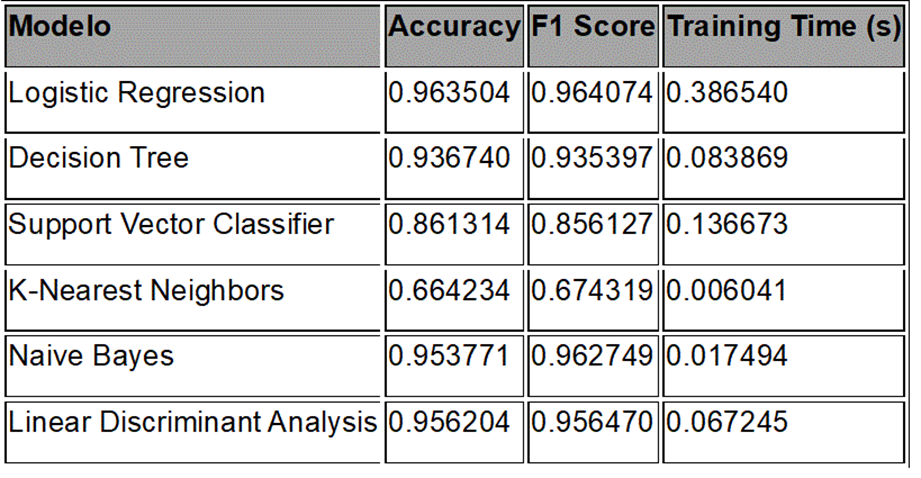


Como se puede observar de los seis modelos, los que mejor desempeño tuvieron fueron Logistic Regression y Naive Bayes. Estos modelos nuevamente fueron entrenados para ver su rendimiento y los resultados no fueron significativos, veamos cada uno.  

Logistic Regression es mejor en Accuracy (0.963504 vs. 0.953771) y F1 Score (0.964074 vs. 0.962749) sobre Naive Bayes, aunqu este último tuvo un menor tiempo de entrenamiento. Es importante resaltar que el tiempo es crucial en escenarios donde el tiempo de entrenamiento es una limitación importante.

Con ajuste de parametros Logistic Regression alcanzó un Accuracy de (0.961071) y F1 Score (0.961925) ligeramente menores en comparación con el modelo sin ajustar (0.963504 y 0.964074).

En Naive Bayes no hay cambios en Accuracy (0.953771) y F1 Score (0.962749) comparado con el modelo sin ajustar.

Por lo que se concluye que en ambos casos los modelos sin ajustar son la mejor opción que realizando el ajuste a los parámetros, como se puede observar a continuación:

  Logistic Regression sin ajustar es la mejor opción si se busca el mejor rendimiento predictivo en términos de Accuracy y F1 Score, con un tiempo de entrenamiento razonable (0.363115 s).

  Naive Bayes sin ajustar es la mejor opción si el tiempo de entrenamiento es una prioridad, ya que proporciona un rendimiento casi comparable en F1 Score con tiempos de entrenamiento extremadamente bajos (0.016687 s).

El ajuste de los modelos no proporcionó mejoreas en términos de rendimiento predictivo y resulta en tiempos de entrenamiento mucho mayores.